In [199]:
#@title funcs
try:
  import tensorflow as tf
  import os
  import pandas as pd
  from Bio.PDB import PDBParser
  import numpy as np
  from Bio.Data import IUPACData
except:
  !pip install biotite -q
  !pip install biopython -q
  import tensorflow as tf
  import os
  import pandas as pd
  from Bio.PDB import PDBParser
  import numpy as np
  from Bio.Data import IUPACData

def get_one_hot_dict():
  amino_acids = IUPACData.protein_letters_3to1
  unique_residues = amino_acids.values()
  one_hot_dict = {res: np.eye(len(unique_residues))[i] for i, res in enumerate(unique_residues)}
  return one_hot_dict

def format_url(request, url):
    # Only use for url in pages. Please DO NOT use for redirects.
    _base_path = request.headers.get('X-Forwarded-Prefix')
    if _base_path:
        # Strip leading/trailing slashes and join base path and URL
        url = os.path.join(_base_path, url)
    return url

from biotite.sequence import ProteinSequence

def three_to_one(amino_acids_3):
    return ProteinSequence.convert_letter_3to1(amino_acids_3)

def standardize(df_column):
    std, mean = np.std(df_column), np.mean(df_column)
    return (df_column - mean) / std

def parse_pdb_to_dataframe(pdb_path, verbose=False):
    amino_acids = IUPACData.protein_letters_3to1
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('pdb', pdb_path)

    data = []
    for model in structure:
        for chain in model:
            for residue in chain:
                # Unique residues (after reset) and CA atomic data
                if 'CA' in residue:
                    atom = residue['CA']
                    data.append([model.id, chain.id, residue.id[1], residue.resname, atom.id, *atom.coord, atom.get_bfactor()])

    df = pd.DataFrame(data, columns=['model', 'chain', 'residue_id', 'residue_name', 'atom', 'X', 'Y', 'Z', 'BFactor'])

    # Change residue names to one-letter codes
    df['residue_name'] = df['residue_name'].apply(three_to_one)

    # Optionally standardize coordinates
    df['X'] = standardize(df['X'])
    df['Y'] = standardize(df['Y'])
    df['Z'] = standardize(df['Z'])

    # Count residues based on unique (chain, residue_id) pairs
    df = df.drop_duplicates(subset=['chain', 'residue_id'], keep='first').reset_index(drop=True)
    print(f"{len(df) } rows after filtering for unique residue ids")

    if verbose:
        unique_residues = df[['chain', 'residue_id']].drop_duplicates()
        print(f"{os.path.basename(pdb_path).split('.')[0]} total number of residues: {len(unique_residues)}")
        for col in df.columns:
            print(f"   > {len(df[col].unique())} unique {col}(s) retrieved.")
    df = df.drop('residue_id', axis=1)
    return df

def prepare_data(pdb_path):
    pdb_df = parse_pdb_to_dataframe(pdb_path)
    sequence = pdb_df['residue_name'].values
    one_hot_dict = get_one_hot_dict()
    one_hot_sequence = np.array([one_hot_dict[aa] for aa in sequence])

    # Normalize coordinates and B-factors
    x, y, z, b = pdb_df['X'].values, pdb_df['Y'].values, pdb_df['Z'].values, pdb_df['BFactor'].values
    x_norm, y_norm, z_norm, b_norm = standardize(x), standardize(y), standardize(z), standardize(b)

    # Create the output array
    flattened_sequences = []
    max_len = 500
    for i in range(min(max_len, len(one_hot_sequence))):
        one_hot = one_hot_sequence[i]
        # Concatenate normalized coordinates and one-hot encoded amino acid
        flattened = np.concatenate([one_hot, x_norm[i:i+1], y_norm[i:i+1], z_norm[i:i+1]])
        flattened_sequences.append(flattened)

    # Convert to a 2D array
    flattened = np.array(flattened_sequences)
    input_shape = (max_len, flattened.shape[1])
    input_data = np.zeros((1, max_len, flattened.shape[1]))
    input_data[0, :len(flattened), :] = flattened

    # Reshape to 2D for DataFrame
    reshaped_input = input_data.reshape(max_len, flattened.shape[1])

    if len(b_norm) < max_len:
        print('padding bnorm')
        b_norm = np.concatenate([b_norm, np.zeros(max_len - len(b_norm))])
    else:
        print('truncating bnorm')
        b_norm = b_norm[:max_len]

    # Return a single 1D array of concatenated inputs and B-factors
    return reshaped_input, b_norm

In [203]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [204]:
import shutil

pdb_files_dir = '/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/'
pdb_file_paths = [os.path.join(pdb_files_dir, file) for file in os.listdir(pdb_files_dir) if file.endswith('.pdb')]
train_dir = '/content/drive/MyDrive/bfactor_transformer/train_x/'
labels_dir = '/content/drive/MyDrive/bfactor_transformer/train_y/'


#clear train dir
if os.path.exists(train_dir):
  shutil.rmtree(train_dir)
os.mkdir(train_dir)

if os.path.exists(labels_dir):
  shutil.rmtree(labels_dir)
os.mkdir(labels_dir)

#populate train dir
for pdb_file_path in pdb_file_paths:
  print(pdb_file_path)
  try:
    reshaped_input, b_norm = prepare_data(pdb_file_path)
    np.save(os.path.join(train_dir, os.path.basename(pdb_file_path).split('.')[0]), reshaped_input)
    np.save(os.path.join(labels_dir, os.path.basename(pdb_file_path).split('.')[0]), b_norm)
  except:
    print('error')
    continue

/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4CDB.pdb
488 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6ACC.pdb
1065 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6DNP.pdb
712 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3LZG.pdb
317 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3JWO.pdb
353 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2V7Y.pdb
504 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2CMZ.pdb
409 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1URZ.pdb
382 rows after filtering for

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7b9f317dab00>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


2570 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1OOP.pdb
819 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8K06.pdb
910 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6CJD.pdb
128 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7XPB.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1792 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1CQT.pdb
308 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1V3B.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1R71.pdb
457 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8BHA.pdb
1680 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5NAL.pdb
150 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5F17.pdb
1286 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6IZO.pdb
741 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2CS1.pdb
92 rows after fil

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8TBY.pdb
2618 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1EPW.pdb
1287 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2RGQ.pdb
401 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7C5M.pdb
1335 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3DPX.pdb
230 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7QE0.pdb
949 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5MN3.pdb
102 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5U0F.pdb
258 rows after fi

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3SL3.pdb
1295 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7O4C.pdb
234 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2LTX.pdb
50 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1WWT.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


88 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3UHO.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7OX5.pdb
2494 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8D82.pdb
2108 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1YLT.pdb
263 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4CFX.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4LLB.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2V00.pdb
330 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8HP7.pdb
723 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4X0K.pdb
888 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4IE5.pdb
er

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7WGW.pdb
0 rows after filtering for unique residue ids
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5A3Q.pdb


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


993 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1KXV.pdb
1232 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7B2M.pdb
1506 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5HX7.pdb
279 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5WZI.pdb
533 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6Z45.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4HTM.pdb
28 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6CPG.pdb
678 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2O00.pdb
37 rows after fi

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


599 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6BYH.pdb
779 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6DRD.pdb
3349 rows after filtering for unique residue ids
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6D6T.pdb
2082 rows after filtering for unique residue ids
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3JVV.pdb
996 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6RZM.pdb
138 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6U3G.pdb
794 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2M8W.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


91 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3MH4.pdb
684 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/191D.pdb
0 rows after filtering for unique residue ids
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5A9J.pdb


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


3158 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4DJB.pdb
235 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4HWJ.pdb
75 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2A9M.pdb
468 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3HA4.pdb
936 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2J6R.pdb
509 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6WWF.pdb
1231 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4EG6.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4H2C.pdb
error
/content/driv

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


660 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1UB2.pdb
700 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6KL2.pdb
442 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4N96.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6PUW.pdb
585 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3RTQ.pdb
806 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1JX4.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7TCP.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4R1M.pdb
1720 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5RXB.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


425 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6WKP.pdb
455 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5LI2.pdb
3162 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3Q2B.pdb
120 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3ZWU.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2VHS.pdb
860 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8OOO.pdb
5364 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8CYZ.pdb
1220 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4Y0L.pdb
80 rows after fil

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


368 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6S2H.pdb
1248 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4R7I.pdb
290 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6AYS.pdb
1832 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1D6H.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6FLO.pdb
549 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1MAZ.pdb
143 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/142L.pdb
162 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3DH2.pdb
380 rows after filter

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6YB6.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2BRX.pdb
427 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1TPO.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6ZCW.pdb
562 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7Z8W.pdb
297 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7T6V.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4QGD.pdb
121 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6VWY.pdb
1251 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3K7X.pdb
348 rows after filtering for unique residue ids
padding bnorm
/content/

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1ZMJ.pdb
219 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2HYJ.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1NXI.pdb
132 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3HOS.pdb
673 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7YDZ.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


888 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8ZM6.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1T3V.pdb
124 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8UF0.pdb
288 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5Z3I.pdb
247 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5WPM.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


214 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8V1R.pdb
1355 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5LWU.pdb
330 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5GVR.pdb
234 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5IWK.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3CHB.pdb
515 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2QJF.pdb
781 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2BUX.pdb
435 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5DPO.pdb
104 rows after filteri

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


220 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1IW7.pdb
6818 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3RWU.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8IP1.pdb
1005 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5AIN.pdb
1030 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7BPY.pdb
562 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6SE2.pdb
360 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7M7A.pdb
2125 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2OWZ.pdb
315 rows afte

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


3976 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3QWT.pdb
1512 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7A03.pdb
987 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2G31.pdb
60 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2GZV.pdb
91 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6N4G.pdb
0 rows after filtering for unique residue ids
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5SJ9.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7MA7.pdb
198 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6UX4.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7URC.pdb
658 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6I17.pdb
484 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7EUV.pdb
133 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4HEF.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3WRQ.pdb
248 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5DYU.pdb
116 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6IJ3.pdb
261 rows afte

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1833 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1G2F.pdb
176 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1NFN.pdb
132 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4MX5.pdb
263 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4LI0.pdb
613 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4HHM.pdb
3088 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7VOV.pdb
182 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5V9G.pdb
620 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfact

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


488 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5MYN.pdb
193 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1L6Y.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3JSY.pdb
418 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6JYY.pdb
706 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7JW6.pdb
226 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3M84.pdb
698 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6QFM.pdb
159 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6Y8A.pdb
error
/content/drive/MyDri

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


215 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3MWE.pdb
744 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8WX6.pdb
358 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1DYP.pdb
271 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2L5F.pdb
92 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1X63.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


82 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6A3I.pdb
1475 rows after filtering for unique residue ids


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3LT8.pdb
69 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3QTX.pdb
294 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3OTR.pdb
2654 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1TJL.pdb
1450 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5JO8.pdb
256 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/9G0B.pdb
802 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8T2D.pdb
190 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5HHW.pdb
306 rows af

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5INI.pdb
2941 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1KID.pdb
193 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7F77.pdb
1269 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5ZQG.pdb
593 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7Y4I.pdb
1637 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5O75.pdb
71 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3ICV.pdb
288 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4D43.pdb
2038 rows after filterin

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


441 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7VUZ.pdb
1097 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6LAV.pdb
129 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2A3H.pdb
300 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2P5V.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8FFY.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2Q0X.pdb
587 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7YAN.pdb
655 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5PBP.pdb
115 rows after filtering for unique residue ids
padding bnorm
/content/drive/M

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1134 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1OC9.pdb
297 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2LNT.pdb
140 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4M90.pdb
154 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3THZ.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1734 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3KH2.pdb
782 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8R62.pdb
0 rows after filtering for unique residue ids
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8G3M.pdb


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8AWM.pdb
726 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4E72.pdb
218 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2NQY.pdb
412 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5Q6C.pdb
341 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6A0I.pdb
609 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8WR0.pdb
3948 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7SRR.pdb
1119 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8T8U.pdb
215 rows after fil

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1619 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6NJA.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4AIN.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2F71.pdb
297 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8TI8.pdb
976 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6MP4.pdb
1089 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6NS0.pdb
1036 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4Z30.pdb
294 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4IZ7.pdb
774 rows after filtering for unique residue ids
truncating bnorm
/content

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


86 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2V2T.pdb
592 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4PJC.pdb

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std



1576 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1Y38.pdb
242 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8HCN.pdb
3099 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3GDL.pdb
514 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4Q44.pdb
684 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8UJG.pdb
1062 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1LGW.pdb
162 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2XK3.pdb
247 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4BLS.pdb
907 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5BVG.pdb
1998 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1SV1.pdb
282 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5FDC.pdb
258 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6F6T.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1350 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6HPI.pdb
158 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8T5W.pdb
177 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4TUF.pdb


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1384 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6PDP.pdb
275 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3HLU.pdb
146 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1XR7.pdb
920 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1UH3.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7PBP.pdb
1968 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5JU9.pdb
167 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5QEP.pdb
284 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8BWY.pdb
14404 rows after filt

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


1557 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1T10.pdb
556 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1M1E.pdb
577 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2BLU.pdb
206 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4RPX.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7KJO.pdb
206 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4PYG.pdb
2055 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3F56.pdb
1232 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3EGW.pdb
error
/content

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6O9S.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5CDH.pdb
2605 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3WF5.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4E0Y.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4UQF.pdb
1860 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3GYE.pdb
598 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8PSM.pdb
3776 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2PUU.pdb
330 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2SNM.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3EST.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2ZQK.pdb
621 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5VCO.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5M8G.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5QHI.pdb
338 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6HSF.pdb
1603 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3MK3.pdb
9240 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4HNE.pdb
694 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4E3Z.pdb
459 rows after filtering for unique residue ids
padding bnorm
/c

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2015 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8PD3.pdb
1028 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5WJE.pdb
163 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4B3L.pdb
2766 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3KQJ.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7KGV.pdb
1628 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1GQK.pdb
1416 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7P8P.pdb
541 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7CXE.pdb
517 rows 

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1077 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8W6G.pdb
1054 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6NDI.pdb
544 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4YIG.pdb
810 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6URA.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4N03.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6UCG.pdb
241 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6T1J.pdb
143 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6ZLP.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4GHJ.pdb
14

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


921 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3LQA.pdb
903 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7RM3.pdb
879 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2C6M.pdb
290 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4WBB.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7NDW.pdb
856 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2HPG.pdb
1263 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7KVB.pdb
1716 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7QMW.pdb
330 rows aft

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1798 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3AVJ.pdb
314 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6KV0.pdb
189 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6GHY.pdb
379 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6HDN.pdb
130 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4GKM.pdb
692 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2QMG.pdb
779 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2LWU.pdb
15 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_tr

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2JFX.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1D3C.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1W8M.pdb
165 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1LY4.pdb
205 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3GMP.pdb
error
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7G97.pdb
414 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3DJZ.pdb
231 rows after filtering for unique residue ids
padding bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5JKJ.pdb
739 rows after filtering for unique residue ids
truncating bnorm
/content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2YLQ.pdb
249 rows after filtering for unique residue ids
padding bnorm
/content/driv

In [207]:
input_vectors = []
label_vectors = []
for file in os.listdir(train_dir):
  try:
    input_vectors.append(np.load(os.path.join(train_dir, file)))
    label_vectors.append(np.load(os.path.join(labels_dir, file)))
  except:
    pass

input_vectors = np.array(input_vectors)
label_vectors = np.array(label_vectors)


In [208]:
input_vectors.shape, label_vectors.shape


((612, 500, 23), (612, 500))

In [209]:
class NaNDetectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        if np.isnan(loss) or np.isnan(val_loss):
            print(f"NaN detected at epoch {epoch}")
            self.model.stop_training = True

nan_detector = NaNDetectorCallback()

In [210]:
import os
import numpy as np
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Clear and create train and labels directories
def clear_and_create_dir(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.mkdir(directory)

clear_and_create_dir(train_dir)
clear_and_create_dir(labels_dir)

# Process pdb files, filter NaNs from resulting data
def process_pdb_files(pdb_file_paths):
    input_data = []
    label_data = []
    for pdb_file_path in pdb_file_paths:
        try:
            reshaped_input, b_norm = prepare_data(pdb_file_path)
            np.save(os.path.join(train_dir, os.path.basename(pdb_file_path).split('.')[0]), reshaped_input)
            np.save(os.path.join(labels_dir, os.path.basename(pdb_file_path).split('.')[0]), b_norm)
        except Exception as e:
            print(f"Error processing {pdb_file_path}: {e}")
    return input_data, label_data

process_pdb_files(pdb_file_paths)

input_vectors = [np.load(os.path.join(train_dir, file)) for file in os.listdir(train_dir)]
label_vectors = [np.load(os.path.join(labels_dir, file)) for file in os.listdir(labels_dir)]

# Check and handle NaNs
def filter_nan(arr_list):
    return [np.nan_to_num(arr, nan=0.0, posinf=1.0, neginf=-1.0) for arr in arr_list]

input_vectors = filter_nan(input_vectors)
label_vectors = filter_nan(label_vectors)

input_vectors = np.array(input_vectors)
label_vectors = np.array(label_vectors)

train_input_vectors, val_input_vectors, train_label_vectors, val_label_vectors = train_test_split(
    input_vectors, label_vectors, test_size=0.2, random_state=42
)

488 rows after filtering for unique residue ids
padding bnorm
1065 rows after filtering for unique residue ids
truncating bnorm
712 rows after filtering for unique residue ids
truncating bnorm
317 rows after filtering for unique residue ids
padding bnorm
353 rows after filtering for unique residue ids
padding bnorm
504 rows after filtering for unique residue ids
truncating bnorm
409 rows after filtering for unique residue ids
padding bnorm
382 rows after filtering for unique residue ids
padding bnorm
426 rows after filtering for unique residue ids
padding bnorm
374 rows after filtering for unique residue ids
padding bnorm
599 rows after filtering for unique residue ids
truncating bnorm
228 rows after filtering for unique residue ids
padding bnorm
284 rows after filtering for unique residue ids
padding bnorm
280 rows after filtering for unique residue ids
padding bnorm
398 rows after filtering for unique residue ids
padding bnorm
362 rows after filtering for unique residue ids
padding b

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1792 rows after filtering for unique residue ids
truncating bnorm
308 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1V3B.pdb: 'CA'
457 rows after filtering for unique residue ids
padding bnorm
1680 rows after filtering for unique residue ids
truncating bnorm
150 rows after filtering for unique residue ids
padding bnorm
1286 rows after filtering for unique residue ids
truncating bnorm
741 rows after filtering for unique residue ids
truncating bnorm
92 rows after filtering for unique residue ids
padding bnorm
424 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7U5X.pdb: 'YOF'
2618 rows after filtering for unique residue ids
truncating bnorm
1287 rows after filtering for unique residue ids
truncating bnorm
401 rows after filtering for unique residue ids
padding bnorm
1335 rows after filtering for unique residue ids
truncating bnorm
230 rows after filtering for unique residue ids
padding bnorm
949 rows after filtering for unique residue ids
truncating bnorm
102 rows after filtering for unique residue ids
padding bnorm
258 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6Q9P.pdb: 'ABH'
1295 rows after filtering for unique residue ids
truncating bnorm
234 rows after filtering for unique residue ids
padding bnorm
50 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


88 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3UHO.pdb: 'DGL'


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


2494 rows after filtering for unique residue ids
truncating bnorm
2108 rows after filtering for unique residue ids
truncating bnorm
263 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4CFX.pdb: 'TPO'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4LLB.pdb: 'ALY'
330 rows after filtering for unique residue ids
padding bnorm
723 rows after filtering for unique residue ids
truncating bnorm
888 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4IE5.pdb: 'MD6'
1351 rows after filtering for unique residue ids
truncating bnorm
993 rows after filtering for unique residue ids
truncating bnorm
680 rows after filtering for unique residue ids
truncating bnorm
371 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3NK8.pdb: 'C

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


0 rows after filtering for unique residue ids
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7WGW.pdb: division by zero


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


993 rows after filtering for unique residue ids
truncating bnorm
1232 rows after filtering for unique residue ids
truncating bnorm
1506 rows after filtering for unique residue ids
truncating bnorm
279 rows after filtering for unique residue ids
padding bnorm
533 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6Z45.pdb: 'TPO'
28 rows after filtering for unique residue ids
padding bnorm
678 rows after filtering for unique residue ids
truncating bnorm
37 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


599 rows after filtering for unique residue ids
truncating bnorm
779 rows after filtering for unique residue ids
truncating bnorm
3349 rows after filtering for unique residue ids
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6DRD.pdb: 'X'
2082 rows after filtering for unique residue ids
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6D6T.pdb: 'X'
996 rows after filtering for unique residue ids
truncating bnorm
138 rows after filtering for unique residue ids
padding bnorm
794 rows after filtering for unique residue ids
truncating bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


91 rows after filtering for unique residue ids
padding bnorm
684 rows after filtering for unique residue ids
truncating bnorm
0 rows after filtering for unique residue ids
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/191D.pdb: division by zero


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


3158 rows after filtering for unique residue ids
truncating bnorm
235 rows after filtering for unique residue ids
padding bnorm
75 rows after filtering for unique residue ids
padding bnorm
468 rows after filtering for unique residue ids
padding bnorm
936 rows after filtering for unique residue ids
truncating bnorm
509 rows after filtering for unique residue ids
truncating bnorm
1231 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4EG6.pdb: 'CAS'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4H2C.pdb: 'CA'
433 rows after filtering for unique residue ids
padding bnorm
222 rows after filtering for unique residue ids
padding bnorm
1647 rows after filtering for unique residue ids
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6VZV.pdb: 'X'
522 rows after filtering for unique residue ids
truncating bnorm
1488 rows after filtering for unique residue ids

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


660 rows after filtering for unique residue ids
truncating bnorm
700 rows after filtering for unique residue ids
truncating bnorm
442 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4N96.pdb: 'CA'
585 rows after filtering for unique residue ids
truncating bnorm
806 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1JX4.pdb: 'CA'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7TCP.pdb: 'CA'
1720 rows after filtering for unique residue ids
truncating bnorm
460 rows after filtering for unique residue ids
padding bnorm
834 rows after filtering for unique residue ids
truncating bnorm
154 rows after filtering for unique residue ids
padding bnorm
140 rows after filtering for unique residue ids
padding bnorm
274 rows after filtering for unique residue ids
padding bnorm
651 rows after filtering for uni

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


425 rows after filtering for unique residue ids
padding bnorm
455 rows after filtering for unique residue ids
padding bnorm
3162 rows after filtering for unique residue ids
truncating bnorm
120 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3ZWU.pdb: 'CA'
860 rows after filtering for unique residue ids
truncating bnorm
5364 rows after filtering for unique residue ids
truncating bnorm
1220 rows after filtering for unique residue ids
truncating bnorm
80 rows after filtering for unique residue ids
padding bnorm
2148 rows after filtering for unique residue ids
truncating bnorm
849 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1LDC.pdb: 'PYR'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1JIA.pdb: 'CA'
341 rows after filtering for unique residue ids
padding bnorm
135 rows after filtering for 

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


368 rows after filtering for unique residue ids
padding bnorm
1248 rows after filtering for unique residue ids
truncating bnorm
290 rows after filtering for unique residue ids
padding bnorm
1832 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1D6H.pdb: 'CSD'
549 rows after filtering for unique residue ids
truncating bnorm
143 rows after filtering for unique residue ids
padding bnorm
162 rows after filtering for unique residue ids
padding bnorm
380 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8ATP.pdb: 'TPO'
334 rows after filtering for unique residue ids
padding bnorm
1160 rows after filtering for unique residue ids
truncating bnorm
145 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3PN7.pdb: 'CA'
536 rows after filtering for uniqu

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6YB6.pdb: 'TYS'
427 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1TPO.pdb: 'CA'
562 rows after filtering for unique residue ids
truncating bnorm
297 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7T6V.pdb: 'PLM'
121 rows after filtering for unique residue ids
padding bnorm
1251 rows after filtering for unique residue ids
truncating bnorm
348 rows after filtering for unique residue ids
padding bnorm
331 rows after filtering for unique residue ids
padding bnorm
152 rows after filtering for unique residue ids
padding bnorm
8886 rows after filtering for unique residue ids
truncating bnorm
239 rows after filtering for unique residue ids
padding bnorm
161 rows after filtering for unique residue ids
padding bnorm
1326 rows after filtering for unique r

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2HYJ.pdb: 'CA'
132 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


673 rows after filtering for unique residue ids
truncating bnorm
888 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8ZM6.pdb: 'CA'
124 rows after filtering for unique residue ids
padding bnorm
288 rows after filtering for unique residue ids
padding bnorm
247 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


214 rows after filtering for unique residue ids
padding bnorm
1355 rows after filtering for unique residue ids
truncating bnorm
330 rows after filtering for unique residue ids
padding bnorm
234 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5IWK.pdb: 'CA'
515 rows after filtering for unique residue ids
truncating bnorm
781 rows after filtering for unique residue ids
truncating bnorm
435 rows after filtering for unique residue ids
padding bnorm
104 rows after filtering for unique residue ids
padding bnorm
87 rows after filtering for unique residue ids
padding bnorm
0 rows after filtering for unique residue ids
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3GJK.pdb: division by zero


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


1112 rows after filtering for unique residue ids
truncating bnorm
220 rows after filtering for unique residue ids
padding bnorm
6818 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3RWU.pdb: 'CA'
1005 rows after filtering for unique residue ids
truncating bnorm
1030 rows after filtering for unique residue ids
truncating bnorm
562 rows after filtering for unique residue ids
truncating bnorm
360 rows after filtering for unique residue ids
padding bnorm
2125 rows after filtering for unique residue ids
truncating bnorm
315 rows after filtering for unique residue ids
padding bnorm
459 rows after filtering for unique residue ids
padding bnorm
261 rows after filtering for unique residue ids
padding bnorm
65 rows after filtering for unique residue ids
padding bnorm
464 rows after filtering for unique residue ids
padding bnorm
681 rows after filtering for unique residue ids
truncating bnorm
Error processing /

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


3976 rows after filtering for unique residue ids
truncating bnorm
1512 rows after filtering for unique residue ids
truncating bnorm
987 rows after filtering for unique residue ids
truncating bnorm
60 rows after filtering for unique residue ids
padding bnorm
91 rows after filtering for unique residue ids
padding bnorm
0 rows after filtering for unique residue ids
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6N4G.pdb: division by zero


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5SJ9.pdb: 'CME'
198 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6UX4.pdb: 'CA'
658 rows after filtering for unique residue ids
truncating bnorm
484 rows after filtering for unique residue ids
padding bnorm
133 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4HEF.pdb: 'NXL'
248 rows after filtering for unique residue ids
padding bnorm
116 rows after filtering for unique residue ids
padding bnorm
261 rows after filtering for unique residue ids
padding bnorm
678 rows after filtering for unique residue ids
truncating bnorm
4040 rows after filtering for unique residue ids
truncating bnorm
789 rows after filtering for unique residue ids
truncating bnorm
1476 rows after filtering for unique residue ids
truncating bnorm
162 rows after filtering for uni

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1833 rows after filtering for unique residue ids
truncating bnorm
176 rows after filtering for unique residue ids
padding bnorm
132 rows after filtering for unique residue ids
padding bnorm
263 rows after filtering for unique residue ids
padding bnorm
613 rows after filtering for unique residue ids
truncating bnorm
3088 rows after filtering for unique residue ids
truncating bnorm
182 rows after filtering for unique residue ids
padding bnorm
620 rows after filtering for unique residue ids
truncating bnorm
353 rows after filtering for unique residue ids
padding bnorm
101 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5FAF.pdb: 'CA'
197 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


488 rows after filtering for unique residue ids
padding bnorm
193 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1L6Y.pdb: 'CME'
418 rows after filtering for unique residue ids
padding bnorm
706 rows after filtering for unique residue ids
truncating bnorm
226 rows after filtering for unique residue ids
padding bnorm
698 rows after filtering for unique residue ids
truncating bnorm
159 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6Y8A.pdb: 'CSO'
295 rows after filtering for unique residue ids
padding bnorm
179 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1G5F.pdb: '2MR'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2BXU.pdb: 'TYS'
0 rows after filtering for unique residue ids
Error processing /content/driv

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


744 rows after filtering for unique residue ids
truncating bnorm
358 rows after filtering for unique residue ids
padding bnorm
271 rows after filtering for unique residue ids
padding bnorm
92 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


82 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1475 rows after filtering for unique residue ids
truncating bnorm
69 rows after filtering for unique residue ids
padding bnorm
294 rows after filtering for unique residue ids
padding bnorm
2654 rows after filtering for unique residue ids
truncating bnorm
1450 rows after filtering for unique residue ids
truncating bnorm
256 rows after filtering for unique residue ids
padding bnorm
802 rows after filtering for unique residue ids
truncating bnorm
190 rows after filtering for unique residue ids
padding bnorm
306 rows after filtering for unique residue ids
padding bnorm
141 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5ACR.pdb: 'OCS'
96 rows after filtering for unique residue ids
padding bnorm
1459 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7D6M.pdb: 'SAM'
1430 rows after filtering for unique residue ids
truncating

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2941 rows after filtering for unique residue ids
truncating bnorm
193 rows after filtering for unique residue ids
padding bnorm
1269 rows after filtering for unique residue ids
truncating bnorm
593 rows after filtering for unique residue ids
truncating bnorm
1637 rows after filtering for unique residue ids
truncating bnorm
71 rows after filtering for unique residue ids
padding bnorm
288 rows after filtering for unique residue ids
padding bnorm
2038 rows after filtering for unique residue ids
truncating bnorm
232 rows after filtering for unique residue ids
padding bnorm
1055 rows after filtering for unique residue ids
truncating bnorm
1087 rows after filtering for unique residue ids
truncating bnorm
291 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6D3U.pdb: 'CA'
1533 rows after filtering for unique residue ids
truncating bnorm
262 rows after filtering for unique residue ids
padding bnorm
0 rows after 

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


441 rows after filtering for unique residue ids
padding bnorm
1097 rows after filtering for unique residue ids
truncating bnorm
129 rows after filtering for unique residue ids
padding bnorm
300 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2P5V.pdb: 'CA'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8FFY.pdb: 'SSA'
587 rows after filtering for unique residue ids
truncating bnorm
655 rows after filtering for unique residue ids
truncating bnorm
115 rows after filtering for unique residue ids
padding bnorm
1226 rows after filtering for unique residue ids
truncating bnorm
3097 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1VL9.pdb: 'CA'
1043 rows after filtering for unique residue ids
truncating bnorm
4102 rows after filtering for unique residue ids
truncating bnorm
266 rows after filtering

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2H9E.pdb: 'DTY'
1134 rows after filtering for unique residue ids
truncating bnorm
297 rows after filtering for unique residue ids
padding bnorm
140 rows after filtering for unique residue ids
padding bnorm
154 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1734 rows after filtering for unique residue ids
truncating bnorm
782 rows after filtering for unique residue ids
truncating bnorm
0 rows after filtering for unique residue ids
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8R62.pdb: division by zero


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8G3M.pdb: 'CA'
726 rows after filtering for unique residue ids
truncating bnorm
218 rows after filtering for unique residue ids
padding bnorm
412 rows after filtering for unique residue ids
padding bnorm
341 rows after filtering for unique residue ids
padding bnorm
609 rows after filtering for unique residue ids
truncating bnorm
3948 rows after filtering for unique residue ids
truncating bnorm
1119 rows after filtering for unique residue ids
truncating bnorm
215 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2FPU.pdb: 'HSO'
2128 rows after filtering for unique residue ids
truncating bnorm
414 rows after filtering for unique residue ids
padding bnorm
4904 rows after filtering for unique residue ids
truncating bnorm
277 rows after filtering for unique residue ids
padding bnorm
1290 rows after filtering for unique residue ids
trunca

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1619 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6NJA.pdb: 'PTR'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4AIN.pdb: 'BET'
297 rows after filtering for unique residue ids
padding bnorm
976 rows after filtering for unique residue ids
truncating bnorm
1089 rows after filtering for unique residue ids
truncating bnorm
1036 rows after filtering for unique residue ids
truncating bnorm
294 rows after filtering for unique residue ids
padding bnorm
774 rows after filtering for unique residue ids
truncating bnorm
714 rows after filtering for unique residue ids
truncating bnorm
704 rows after filtering for unique residue ids
truncating bnorm
3918 rows after filtering for unique residue ids
truncating bnorm
341 rows after filtering for unique residue ids
padding bnorm
280 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


86 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


592 rows after filtering for unique residue ids
truncating bnorm
1576 rows after filtering for unique residue ids
truncating bnorm
242 rows after filtering for unique residue ids
padding bnorm
3099 rows after filtering for unique residue ids
truncating bnorm
514 rows after filtering for unique residue ids
truncating bnorm
684 rows after filtering for unique residue ids
truncating bnorm
1062 rows after filtering for unique residue ids
truncating bnorm
162 rows after filtering for unique residue ids
padding bnorm
247 rows after filtering for unique residue ids
padding bnorm
413 rows after filtering for unique residue ids
padding bnorm
75 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


682 rows after filtering for unique residue ids
truncating bnorm
907 rows after filtering for unique residue ids
truncating bnorm
1998 rows after filtering for unique residue ids
truncating bnorm
282 rows after filtering for unique residue ids
padding bnorm
258 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1350 rows after filtering for unique residue ids
truncating bnorm
158 rows after filtering for unique residue ids
padding bnorm
177 rows after filtering for unique residue ids
padding bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1384 rows after filtering for unique residue ids
truncating bnorm
275 rows after filtering for unique residue ids
padding bnorm
146 rows after filtering for unique residue ids
padding bnorm
920 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1UH3.pdb: 'CA'
1968 rows after filtering for unique residue ids
truncating bnorm
167 rows after filtering for unique residue ids
padding bnorm
284 rows after filtering for unique residue ids
padding bnorm
14404 rows after filtering for unique residue ids
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/8BWY.pdb: 'X'
158 rows after filtering for unique residue ids
padding bnorm
308 rows after filtering for unique residue ids
padding bnorm
926 rows after filtering for unique residue ids
truncating bnorm
471 rows after filtering for unique residue ids
padding bnorm
142 rows after filtering for unique residue ids
padding bnorm
111 rows after 

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


1557 rows after filtering for unique residue ids
truncating bnorm
556 rows after filtering for unique residue ids
truncating bnorm
577 rows after filtering for unique residue ids
truncating bnorm
206 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4RPX.pdb: 'CA'
206 rows after filtering for unique residue ids
padding bnorm
2055 rows after filtering for unique residue ids
truncating bnorm
1232 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3EGW.pdb: 'FME'
400 rows after filtering for unique residue ids
padding bnorm
2550 rows after filtering for unique residue ids
truncating bnorm
2062 rows after filtering for unique residue ids
truncating bnorm
813 rows after filtering for unique residue ids
truncating bnorm
367 rows after filtering for unique residue ids
padding bnorm
642 rows after filtering for unique residue ids


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6O9S.pdb: 'NXL'
2605 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3WF5.pdb: 'TPO'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4E0Y.pdb: 'PTR'
1860 rows after filtering for unique residue ids
truncating bnorm
598 rows after filtering for unique residue ids
truncating bnorm
3776 rows after filtering for unique residue ids
truncating bnorm
330 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2SNM.pdb: 'CA'
968 rows after filtering for unique residue ids
truncating bnorm
56 rows after filtering for unique residue ids
padding bnorm
912 rows after filtering for unique residue ids
truncating bnorm


<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3EST.pdb: 'CA'
621 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5VCO.pdb: 'CA'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5M8G.pdb: 'CA'
338 rows after filtering for unique residue ids
padding bnorm
1603 rows after filtering for unique residue ids
truncating bnorm
9240 rows after filtering for unique residue ids
truncating bnorm
694 rows after filtering for unique residue ids
truncating bnorm
459 rows after filtering for unique residue ids
padding bnorm
418 rows after filtering for unique residue ids
padding bnorm
1602 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1KLM.pdb: 'CSD'
0 rows after filtering for unique residue ids
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1Q9A.pdb:

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2015 rows after filtering for unique residue ids
truncating bnorm
1028 rows after filtering for unique residue ids
truncating bnorm
163 rows after filtering for unique residue ids
padding bnorm
2766 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3KQJ.pdb: 'IAS'
1628 rows after filtering for unique residue ids
truncating bnorm
1416 rows after filtering for unique residue ids
truncating bnorm
541 rows after filtering for unique residue ids
truncating bnorm
517 rows after filtering for unique residue ids
truncating bnorm
192 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5B6J.pdb: 'CSO'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1J9C.pdb: '0Z6'
494 rows after filtering for unique residue ids
padding bnorm
74 rows after filtering for unique residue ids
padding bnorm
1060 rows after filteri

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1054 rows after filtering for unique residue ids
truncating bnorm
544 rows after filtering for unique residue ids
truncating bnorm
810 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6URA.pdb: 'KCX'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4N03.pdb: 'PLM'
241 rows after filtering for unique residue ids
padding bnorm
143 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6ZLP.pdb: 'CA'
149 rows after filtering for unique residue ids
padding bnorm
304 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1SRR.pdb: 'CA'
602 rows after filtering for unique residue ids
truncating bnorm
1149 rows after filtering for unique residue ids
truncating bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_fil

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


921 rows after filtering for unique residue ids
truncating bnorm
903 rows after filtering for unique residue ids
truncating bnorm
879 rows after filtering for unique residue ids
truncating bnorm
290 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4WBB.pdb: 'SEP'
856 rows after filtering for unique residue ids
truncating bnorm
1263 rows after filtering for unique residue ids
truncating bnorm
1716 rows after filtering for unique residue ids
truncating bnorm
330 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/4QSH.pdb: 'FLC'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1UWW.pdb: 'CA'
439 rows after filtering for unique residue ids
padding bnorm
1036 rows after filtering for unique residue ids
truncating bnorm
385 rows after filtering for unique residue ids
padding bnorm
250 rows after filtering 

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


1798 rows after filtering for unique residue ids
truncating bnorm
314 rows after filtering for unique residue ids
padding bnorm
189 rows after filtering for unique residue ids
padding bnorm
379 rows after filtering for unique residue ids
padding bnorm
130 rows after filtering for unique residue ids
padding bnorm
692 rows after filtering for unique residue ids
truncating bnorm
779 rows after filtering for unique residue ids
truncating bnorm
15 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2M60.pdb: 'FME'
242 rows after filtering for unique residue ids
padding bnorm
221 rows after filtering for unique residue ids
padding bnorm
316 rows after filtering for unique residue ids
padding bnorm
1883 rows after filtering for unique residue ids
truncating bnorm
194 rows after filtering for unique residue ids
padding bnorm
251 rows after filtering for unique residue ids
padding bnorm
Error processing /content/dri

<ipython-input-199-743ae59d08f1>:40: RuntimeWarning: invalid value encountered in divide
  return (df_column - mean) / std


Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2JFX.pdb: 'DGL'
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/1D3C.pdb: 'CA'
165 rows after filtering for unique residue ids
padding bnorm
205 rows after filtering for unique residue ids
padding bnorm
Error processing /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3GMP.pdb: 'PLM'
414 rows after filtering for unique residue ids
padding bnorm
231 rows after filtering for unique residue ids
padding bnorm
739 rows after filtering for unique residue ids
truncating bnorm
249 rows after filtering for unique residue ids
padding bnorm
2752 rows after filtering for unique residue ids
truncating bnorm
325 rows after filtering for unique residue ids
padding bnorm


In [ ]:
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(3):
        x = SingleHeadSelfAttention(output_dim=input_shape[-1])(x)
        x = tf.keras.layers.Add()([inputs, x])
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(3000)(x)
    x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.Dense(600)(x)
    outputs = tf.keras.layers.Dense(500)(x)
    model = tf.keras.Model(inputs, outputs)
    return model


model = build_model(input_vectors.shape[1:])
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

history = model.fit(
    train_input_vectors, train_label_vectors,
    validation_data=(val_input_vectors, val_label_vectors),
    epochs=75,
    batch_size=60,
    callbacks=[nan_detector]
)

model.save('single_head_self_attention_model.h5')

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46            │ (None, 500, 23)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ single_head_self_attenti… │ (None, 500, 23)        │          1,587 │ input_layer_46[0][0]   │
│ (SingleHeadSelfAttention) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_316 (Add)             │ (None, 500, 23)        │              0 │ input_layer_46[0][0],  │
│                           │                        │                │ single_head_self_atte… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ single_head_self_attenti… │ (None, 500, 23)        │          1,587 │ add_316[0][0]          │
│ (SingleHeadSelfAttention) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_317 (Add)             │ (None, 500, 23)        │              0 │ input_layer_46[0][0],  │
│                           │                        │                │ single_head_self_atte… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ single_head_self_attenti… │ (None, 500, 23)        │          1,587 │ add_317[0][0]          │
│ (SingleHeadSelfAttention) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_318 (Add)             │ (None, 500, 23)        │              0 │ input_layer_46[0][0],  │
│                           │                        │                │ single_head_self_atte… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_43 (Flatten)      │ (None, 11500)          │              0 │ add_318[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_97 (Dense)          │ (None, 3000)           │     34,503,000 │ flatten_43[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_98 (Dense)          │ (None, 1000)           │      3,001,000 │ dense_97[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_99 (Dense)          │ (None, 600)            │        600,600 │ dense_98[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_100 (Dense)         │ (None, 500)            │        300,500 │ dense_99[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,409,861 (146.52 MB)

 Trainable params: 38,409,861 (146.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.9598 - val_loss: 0.9705
Epoch 2/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 1.0892 - val_loss: 0.8685
Epoch 3/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.8312 - val_loss: 0.7795
Epoch 4/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.6652 - val_loss: 0.7368
Epoch 5/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.5690 - val_loss: 0.7167
Epoch 6/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.4806 - val_loss: 0.7007
Epoch 7/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.4537 - val_loss: 0.6912
Epoch 8/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.4142 - val_loss: 0.6870
Epoch 9/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.3788 - val_loss: 0.6783
Epoch 10/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.3614 - val_loss: 0.6759
Epoch 11/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.3608 - val_loss: 0.6771
Epoch 12/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.3526 - val_loss: 0.6701
Epoch 13/75
9

In [ ]:
import matplotlib.pyplot as plt

class SingleHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(SingleHeadSelfAttention, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        self.W_q = self.add_weight(shape=(input_shape[-1], self.output_dim), initializer='random_normal', trainable=True)
        self.W_k = self.add_weight(shape=(input_shape[-1], self.output_dim), initializer='random_normal', trainable=True)
        self.W_v = self.add_weight(shape=(input_shape[-1], self.output_dim), initializer='random_normal', trainable=True)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.W_q)
        K = tf.matmul(inputs, self.W_k)
        V = tf.matmul(inputs, self.W_v)

        attention_scores = tf.matmul(Q, K, transpose_b=True)
        attention_scores = tf.math.softmax(attention_scores, axis=-1)

        attention_output = tf.matmul(attention_scores, V)
        return attention_output

    def get_config(self):
        config = super(SingleHeadSelfAttention, self).get_config()
        config.update({"output_dim": self.output_dim})
        return config

# Function to load the model and make predictions
def predict_bfactors(pdb_file_path, model_path='single_head_self_attention_model.h5'):
    pdb_df_raw = parse_pdb_to_dataframe(pdb_file_path)
    len_pdb = len(pdb_df_raw)
    # Load the trained model
    custom_objects = {'SingleHeadSelfAttention': SingleHeadSelfAttention}
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

    # Prepare the input data from the PDB file
    reshaped_input, actual_bfactors = prepare_data(pdb_file_path)

    # Make predictions using the model
    input_data = np.expand_dims(reshaped_input, axis=0)  # Add batch dimension to input
    predicted_bfactors = model.predict(input_data)

    # Flatten the arrays since we are only predicting a single sample
    actual_bfactors = actual_bfactors.flatten()
    predicted_bfactors = predicted_bfactors.flatten()
    predicted_bfactors_truncated = predicted_bfactors[:len_pdb]
    actual_bfactors_truncated = actual_bfactors[:len_pdb]

    return actual_bfactors_truncated, predicted_bfactors_truncated

def smooth_list(lst, window_size):
    smoothed = []
    for i in range(len(lst)):
        start = max(0, i - window_size // 2)
        end = min(len(lst), i + window_size // 2 + 1)
        smoothed.append(np.mean(lst[start:end]))
    return smoothed

/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/4XFX.pdb
216 rows after filtering for unique residue ids


216 rows after filtering for unique residue ids
padding bnorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Correlation: 0.09677571485875765


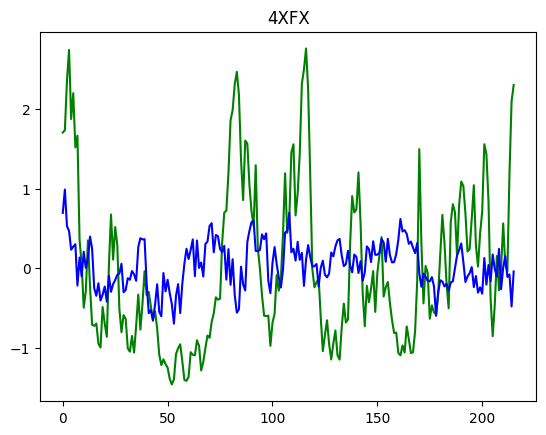

Correlation: 0.27601867649090017


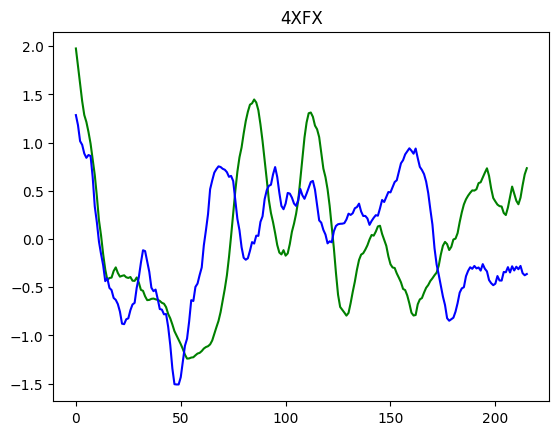

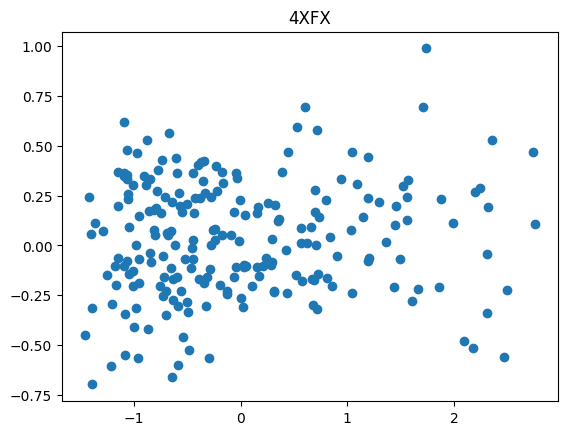

/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/3TG7.pdb
889 rows after filtering for unique residue ids


889 rows after filtering for unique residue ids
truncating bnorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Correlation: -0.16600571060846883


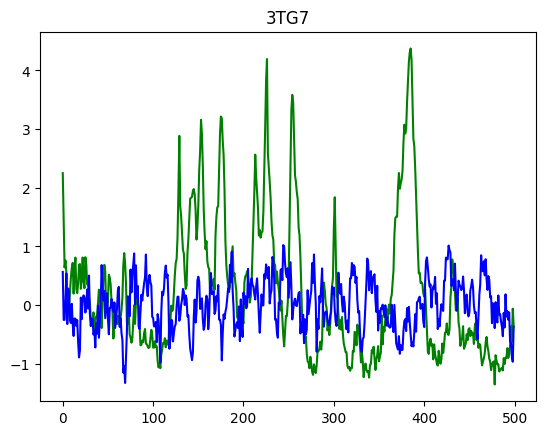

Correlation: -0.25805063365488745


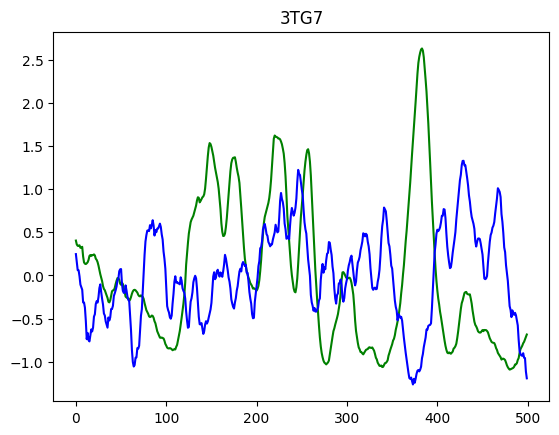

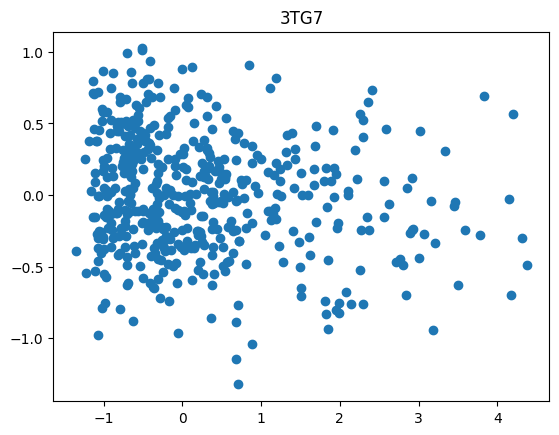

/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/2QLE.pdb
226 rows after filtering for unique residue ids


226 rows after filtering for unique residue ids
padding bnorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Correlation: 0.07578032455668225


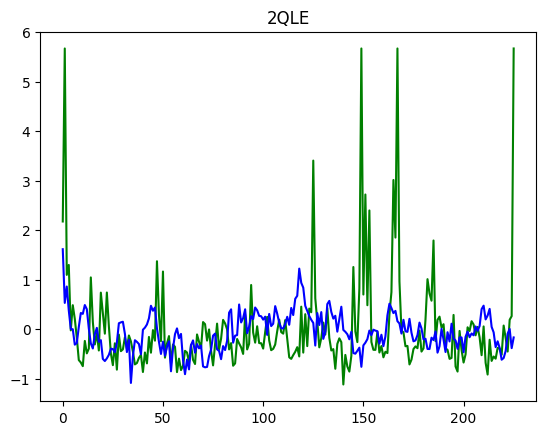

Correlation: 0.26535856352693366


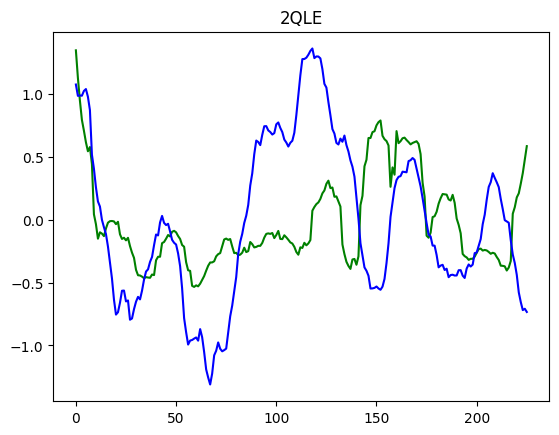

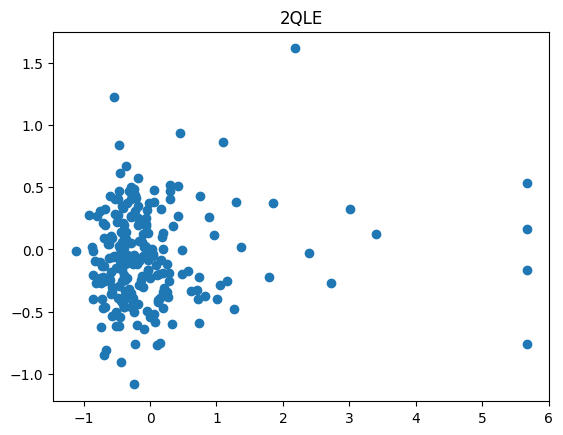

/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/1R88.pdb
267 rows after filtering for unique residue ids


267 rows after filtering for unique residue ids
padding bnorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Correlation: 0.09547936243687476


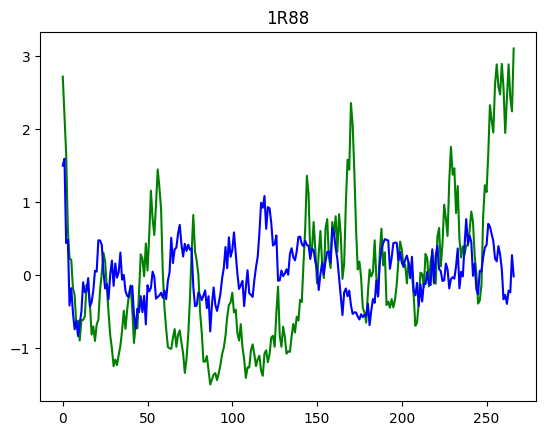

Correlation: -0.026303974767200936


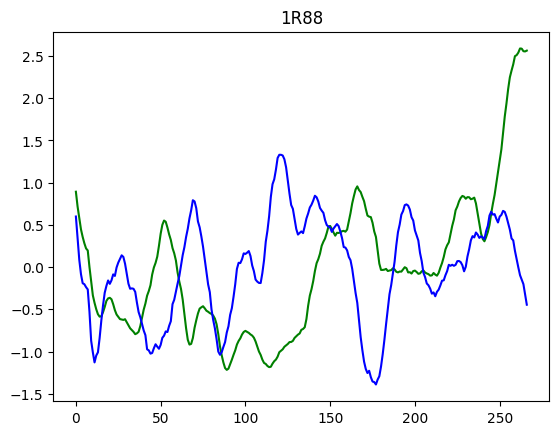

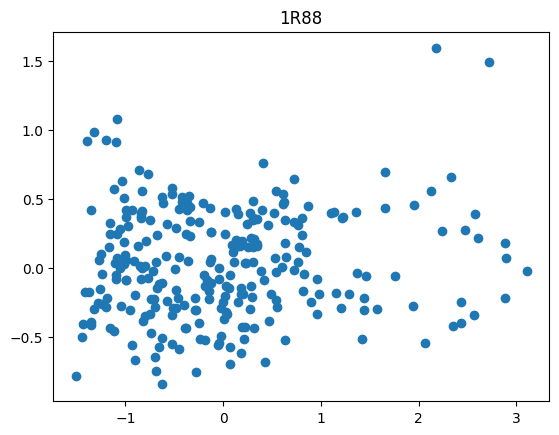

/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/1WTU.pdb
198 rows after filtering for unique residue ids


198 rows after filtering for unique residue ids
padding bnorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Correlation: -0.09636316301589003


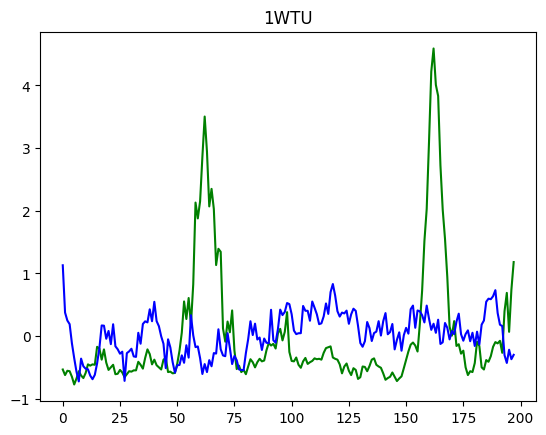

Correlation: -0.1284455169897884


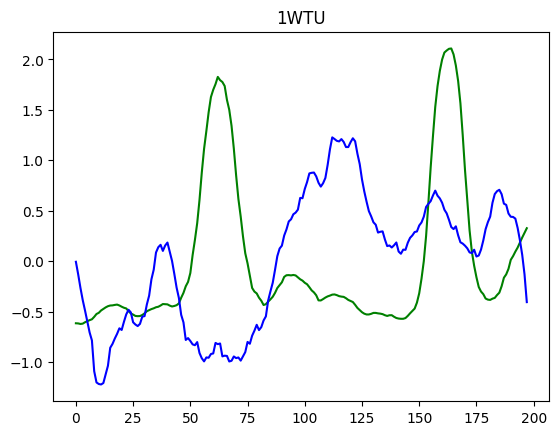

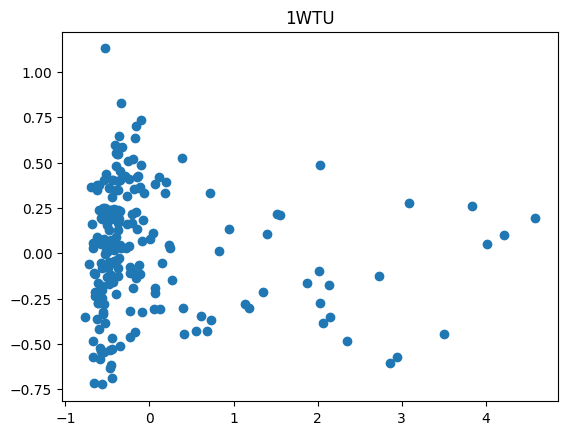

/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/2Z19.pdb
129 rows after filtering for unique residue ids


129 rows after filtering for unique residue ids
padding bnorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Correlation: -0.010161517330499713


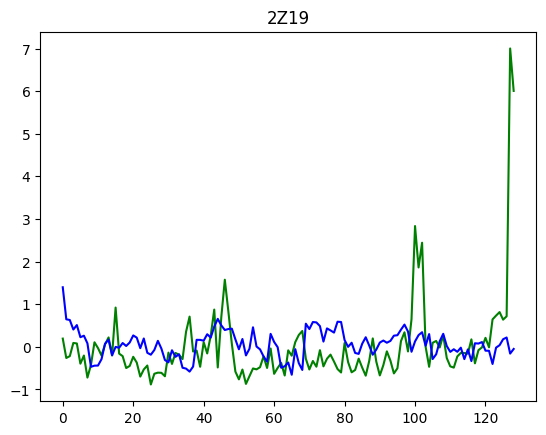

Correlation: -0.030683084466049046


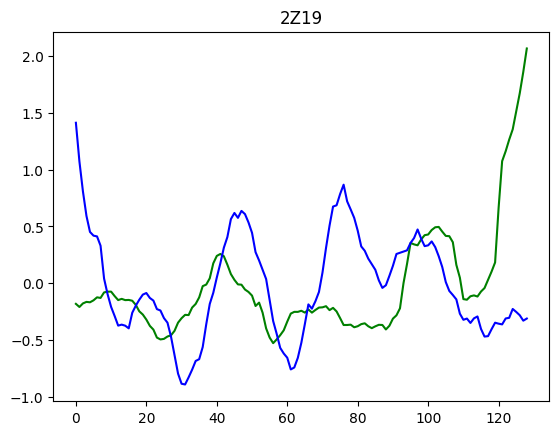

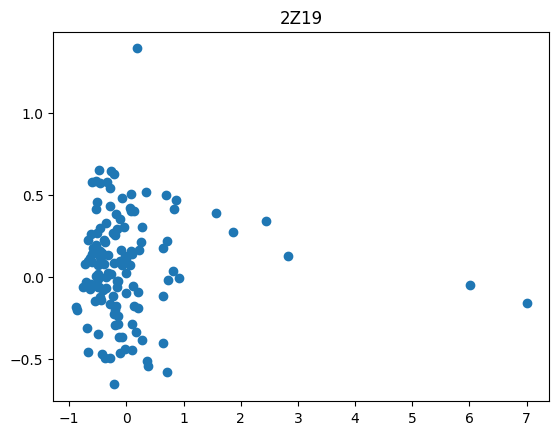

/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/3OB4.pdb
474 rows after filtering for unique residue ids


474 rows after filtering for unique residue ids
padding bnorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Correlation: 0.07447284563843366


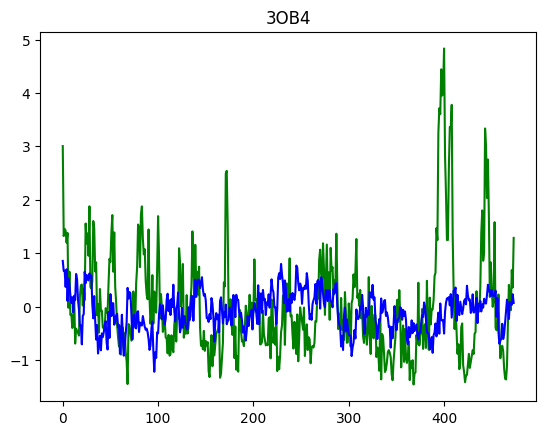

Correlation: 0.04580517240144643


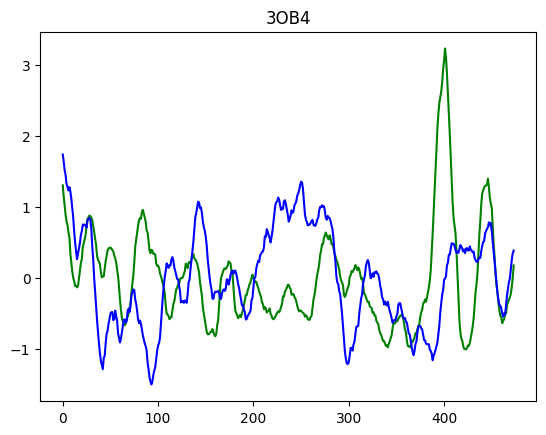

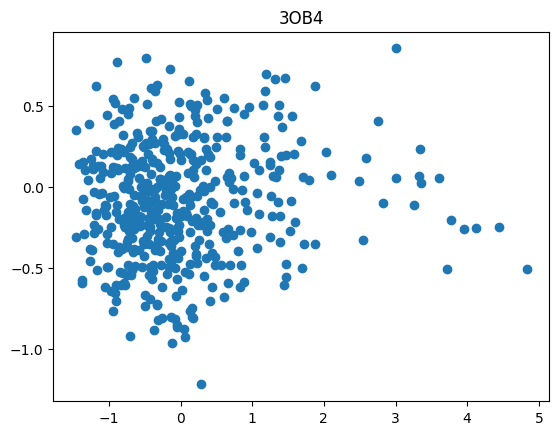

/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/4AXG.pdb
400 rows after filtering for unique residue ids


400 rows after filtering for unique residue ids
padding bnorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Correlation: 0.04633861551248087


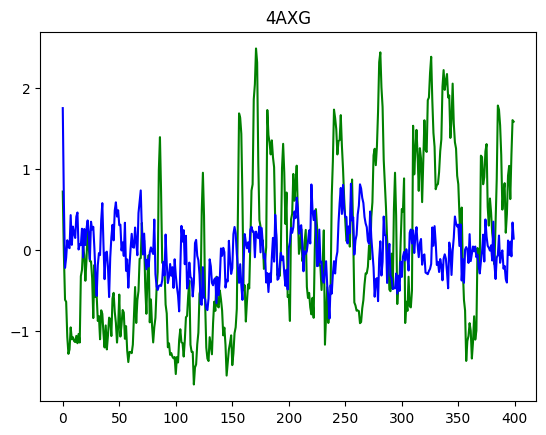

Correlation: 0.05767784613056628


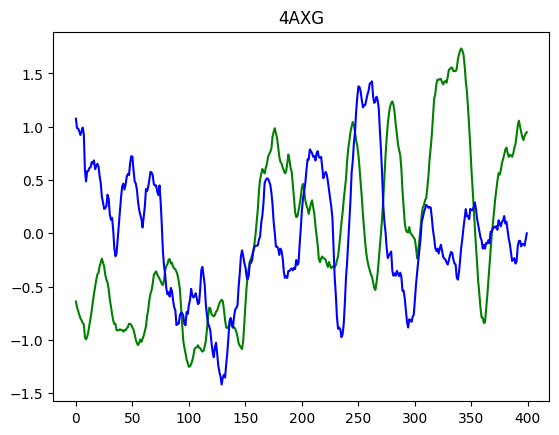

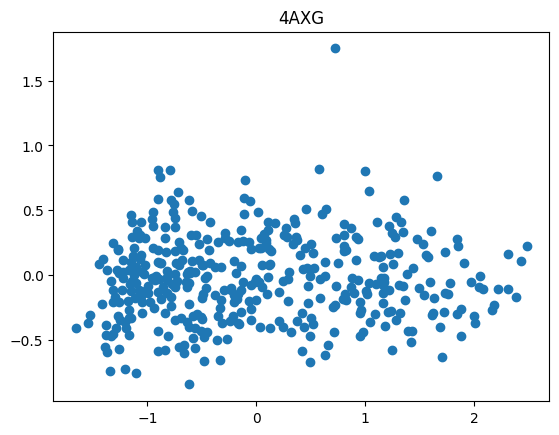

/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/4W85.pdb
678 rows after filtering for unique residue ids


678 rows after filtering for unique residue ids
truncating bnorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Correlation: -0.10829876909342633


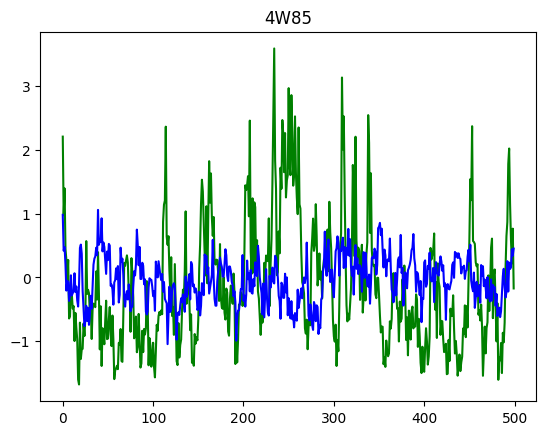

Correlation: -0.18827089223531054


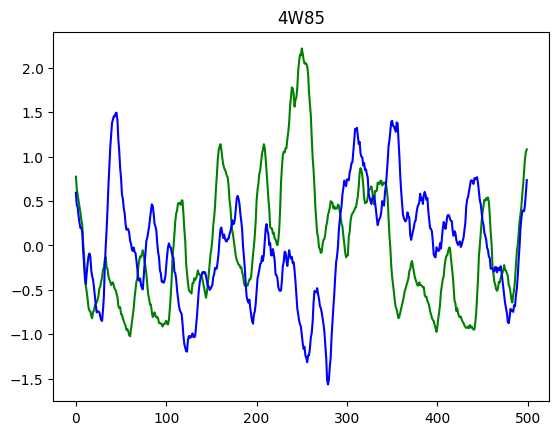

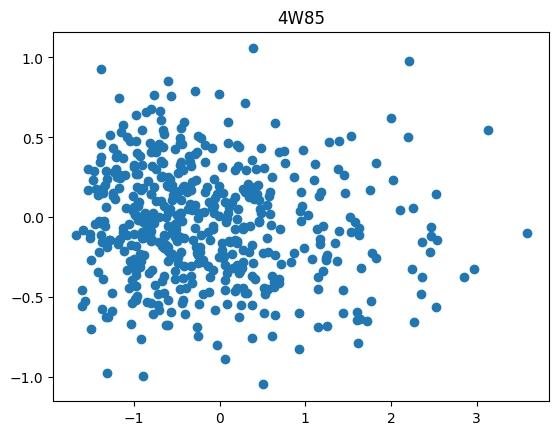

/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/3EVT.pdb
310 rows after filtering for unique residue ids


310 rows after filtering for unique residue ids
padding bnorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Correlation: 0.28666927190102404


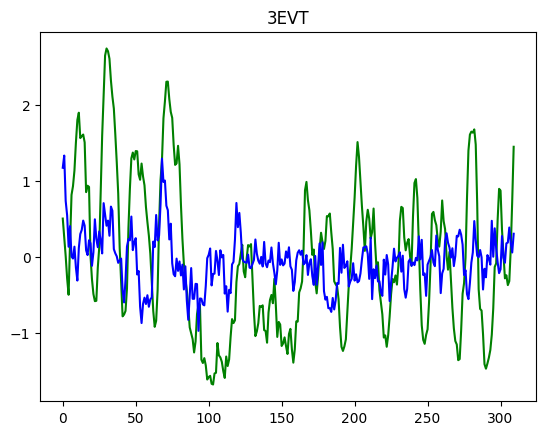

Correlation: 0.5256279864146511


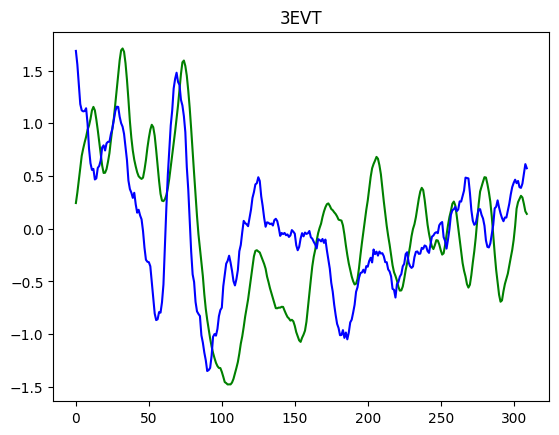

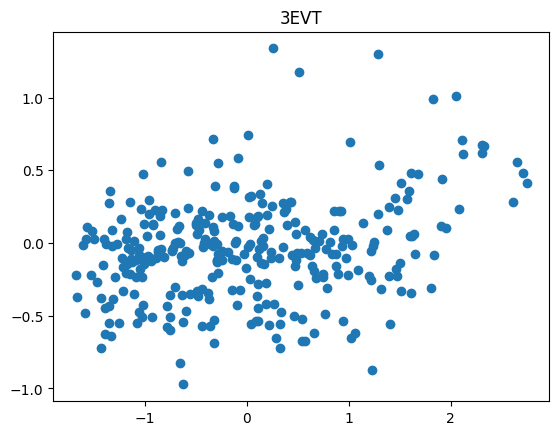

/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/1CU2.pdb
162 rows after filtering for unique residue ids


162 rows after filtering for unique residue ids
padding bnorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Correlation: 0.6906110201670136


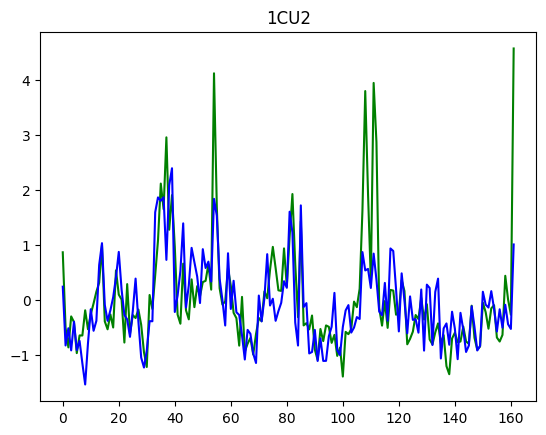

Correlation: 0.8546600000662701


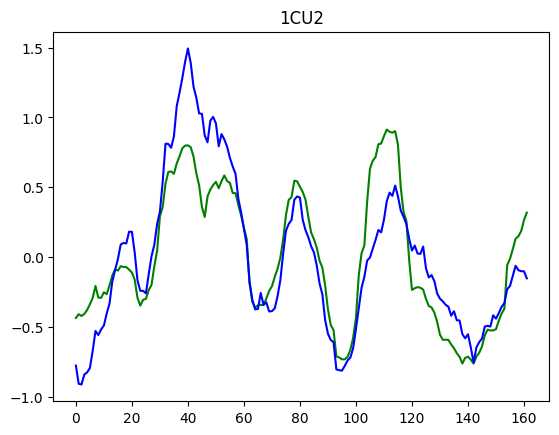

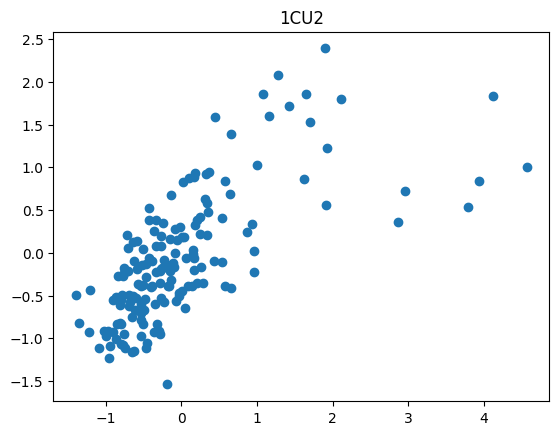

In [194]:
results = []
pdb_files_dir = '/content/drive/MyDrive/bfactor_transformer/test_pdb_files_dir/'
for pdb_file_path in [os.path.join(pdb_files_dir, f) for f in os.listdir(pdb_files_dir) if f.endswith('.pdb')]:
  print(pdb_file_path)
  stub = '.'.join(os.path.basename(pdb_file_path).split('.')[:-1])
  #pdb_file_path = '/content/pdb_files_dir/1AOL.pdb'
  true_bfactors, pred_bfactors = predict_bfactors(pdb_file_path)
  corr = np.corrcoef(true_bfactors, pred_bfactors)[0, 1]
  print(f"Correlation: {corr}")
  plt.plot(true_bfactors, label='True B-factors', c='g')
  plt.plot(pred_bfactors, label='Predicted B-factors', c='b')
  plt.title(stub)
  plt.show()

  smoothed_true_bfactors = smooth_list(standardize(true_bfactors), 15)
  smoothed_pred_bfactors = smooth_list(standardize(pred_bfactors), 15)

  corr = np.corrcoef(smoothed_true_bfactors, smoothed_pred_bfactors)[0, 1]
  print(f"Correlation: {corr}")
  plt.plot(smoothed_true_bfactors, label='True B-factors', c='g')
  plt.plot(smoothed_pred_bfactors, label='Predicted B-factors', c='b')
  plt.title(stub)
  plt.show()
  #
  plt.title(stub)
  plt.scatter(true_bfactors, pred_bfactors)
  plt.show()
  results.append({'pdb_path': pdb_file_path, 'corr': corr})

In [196]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='corr', ascending=False)
results_df

,pdb_path,corr
10,/content/drive/MyDrive/bfactor_transformer/tes...,0.854660
9,/content/drive/MyDrive/bfactor_transformer/tes...,0.525628
0,/content/drive/MyDrive/bfactor_transformer/tes...,0.276019
2,/content/drive/MyDrive/bfactor_transformer/tes...,0.265359
7,/content/drive/MyDrive/bfactor_transformer/tes...,0.057678
6,/content/drive/MyDrive/bfactor_transformer/tes...,0.045805
3,/content/drive/MyDrive/bfactor_transformer/tes...,-0.026304
5,/content/drive/MyDrive/bfactor_transformer/tes...,-0.030683
4,/content/drive/MyDrive/bfactor_transformer/tes...,-0.128446
8,/content/drive/MyDrive/bfactor_transformer/tes...,-0.188271


<BarContainer object of 11 artists>

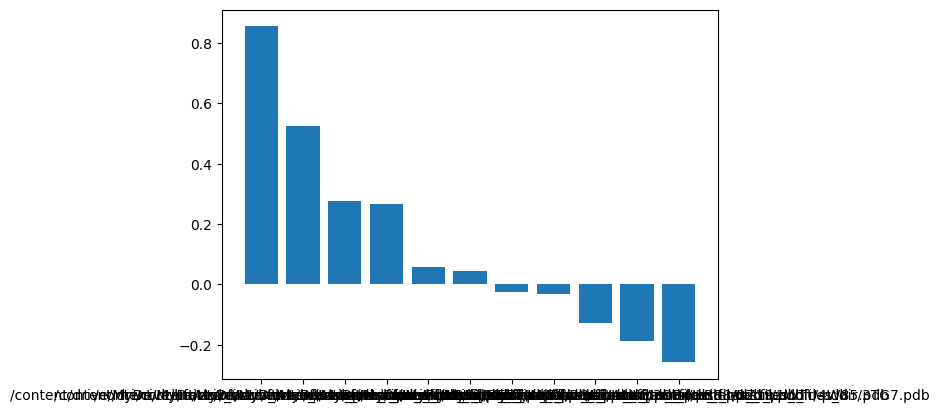

In [197]:
plt.bar(results_df['pdb_path'], results_df['corr'])

In [188]:
results_df['corr'].mean()

0.886520124499408

In [61]:
import requests
import time
import numpy as np

def get_pdb_data(start, rows):
    url = 'https://search.rcsb.org/rcsbsearch/v2/query'
    headers = {'Content-Type': 'application/json'}

    query = {
        "query": {
            "type": "terminal",
            "service": "text",
            "parameters": {
                "attribute": "rcsb_id",
                "operator": "exists"
            }
        },
        "request_options": {
            "paginate": {
                "start": start,
                "rows": rows
            }
        },
        "return_type": "entry"
    }

    try:
        response = requests.post(url, headers=headers, json=query)
        response.raise_for_status()
        response_json = response.json()
        if 'result_set' in response_json:
            return [result['identifier'] for result in response_json['result_set']], response_json['total_count']
        else:
            print("No results found in response.")
            return [], 0
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        if response.status_code == 400:
            print(f"Response content: {response.text}")
        return [], 0

# Sampling every 100th for testing
def get_sampled_pdb_ids():
    all_pdb_ids = []
    total_n_pdb_ids = 0
    chunk_size = 100

    _, total_n_pdb_ids = get_pdb_data(0, 1)
    n_total_pdb_ids = total_n_pdb_ids

    print(f"Total PDB IDs available: {n_total_pdb_ids}")

    sampled_ids = []
    for start in range(0, n_total_pdb_ids, 10000):  # Fetch chunks of 10,000 to be efficient
        pdb_ids, _ = get_pdb_data(start, 10000)
        all_pdb_ids.extend(pdb_ids)

        print(f"Fetched {len(all_pdb_ids)} PDB IDs so far...")
        time.sleep(np.random.random())

        sampled_ids.extend(pdb_ids[::100]) #for testing

        if len(sampled_ids) >= 10000:
            break

    return sampled_ids

# Fetch PDB IDs
pdb_ids = get_sampled_pdb_ids()
print(f"Total PDB IDs fetched: {len(pdb_ids)}")
print(pdb_ids[0], pdb_ids[-1])

Total PDB IDs available: 225158
Fetched 10000 PDB IDs so far...
Fetched 20000 PDB IDs so far...
Fetched 30000 PDB IDs so far...
Fetched 40000 PDB IDs so far...
Fetched 50000 PDB IDs so far...
Fetched 60000 PDB IDs so far...
Fetched 70000 PDB IDs so far...
Fetched 80000 PDB IDs so far...
Fetched 90000 PDB IDs so far...
Fetched 100000 PDB IDs so far...
Fetched 110000 PDB IDs so far...
Fetched 120000 PDB IDs so far...
Fetched 130000 PDB IDs so far...
Fetched 140000 PDB IDs so far...
Fetched 150000 PDB IDs so far...
Fetched 160000 PDB IDs so far...
Fetched 170000 PDB IDs so far...
Fetched 180000 PDB IDs so far...
Fetched 190000 PDB IDs so far...
Fetched 200000 PDB IDs so far...
Fetched 210000 PDB IDs so far...
Fetched 220000 PDB IDs so far...
Fetched 225158 PDB IDs so far...
Total PDB IDs fetched: 2252
100D 9IT1


In [198]:
#@title Sample from RCSB Protein Data Bank
def download_pdb(pdb_id, download_folder):
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    response = requests.get(url)

    if response.status_code == 200:
        os.makedirs(download_folder, exist_ok=True)  # Create the directory if it doesn’t exist
        file_path = os.path.join(download_folder, f'{pdb_id}.pdb')

        with open(file_path, 'wb') as pdb_file:
            pdb_file.write(response.content)

        print(f'Successfully downloaded {pdb_id} to {file_path}')
        return file_path
    else:
        print(f'Failed to download {pdb_id}. HTTP status code: {response.status_code}')
        return None

download_folder = '/content/drive/MyDrive/bfactor_transformer/pdb_files_dir'  # Specify your download folder

sample_size = 500
sampled_pdb_ids = np.random.choice(pdb_ids, size=sample_size, replace=False)

for pdb_id in sampled_pdb_ids:
  downloaded_file_path = download_pdb(pdb_id, download_folder)
print(f'Downloaded file path: {downloaded_file_path}')

Successfully downloaded 7P5Q to /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7P5Q.pdb
Successfully downloaded 3QWT to /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/3QWT.pdb
Successfully downloaded 7A03 to /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7A03.pdb
Successfully downloaded 2G31 to /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2G31.pdb
Successfully downloaded 2GZV to /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/2GZV.pdb
Successfully downloaded 6N4G to /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6N4G.pdb
Successfully downloaded 5SJ9 to /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/5SJ9.pdb
Successfully downloaded 7MA7 to /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7MA7.pdb
Successfully downloaded 6UX4 to /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/6UX4.pdb
Successfully downloaded 7URC to /content/drive/MyDrive/bfactor_transformer/pdb_files_dir/7URC.pdb
Successfully downloa